## Sudoku

<img src="data/sudoku.jpg" width='200px'>

Load an RGB image from `sudoku.jpg` or an arbitrary file from `/home/course/ImageExploration/Sudoku/` folder. Convert it to grayscale. Try to find the border of the sudoku table and correct for the perspective until the table looks as rectangular as possible. Check if the image suffers from the camera lens distortion. Find the squares containing numbers and propose an algorythm to recognize the numbers?

* Hint: we will need a transformation at some point https://www.youtube.com/watch?v=PtCQH93GucA

In [1]:
import cv2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from copy import deepcopy

from sklearn.cluster import KMeans

In [2]:
matplotlib.rcParams["figure.figsize"] = (8, 6)
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 13

matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.grid"] = False
matplotlib.rcParams["xtick.major.size"] = 12
matplotlib.rcParams["ytick.major.size"] = 12
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams["ytick.major.width"] = 2

### Load image

(<matplotlib.image.AxesImage at 0x23e5d82ed90>, (480, 640))

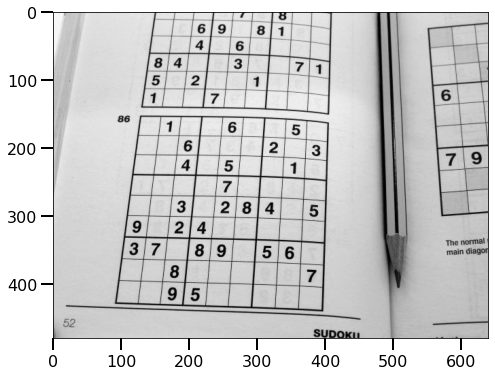

In [3]:
img = cv2.imread('data/sudoku.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert to grayscale
original = deepcopy(gray)
plt.imshow(gray, cmap="gray"), gray.shape

## Finding the border and perspective transformation

Text(0.5, 1.0, 'Original image')

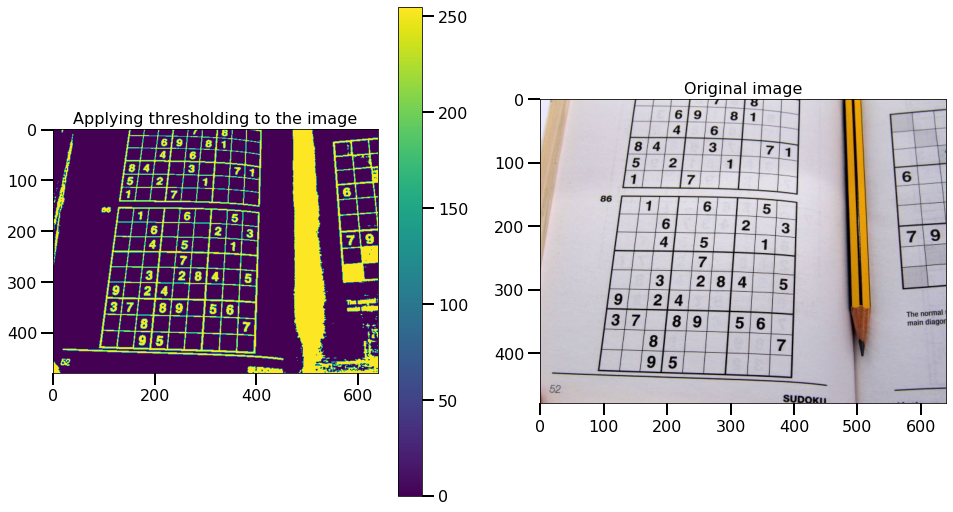

In [4]:
blur_img = cv2.blur(gray, (2,2))  #blurring the image to reduce noise

fig, ax = plt.subplots(1,2,figsize=[16,9])

#Applying thresholding: it transforms the picture pixelwise
#The pixels are mapped to either 0 or 255 based on their intensity. 
# When the intensity is high (>180 in this case) it is mapped to 255,
# when it is low, then 0.
_,threshed = cv2.threshold(blur_img, 180, 255,cv2.THRESH_BINARY_INV) 

ax[0].set_title("Applying thresholding to the image")
mappable = ax[0].imshow(threshed)
plt.colorbar(mappable, ax = ax[0])

ax[1].imshow(img)
ax[1].set_title("Original image")

Text(0.5, 1.0, 'Original image')

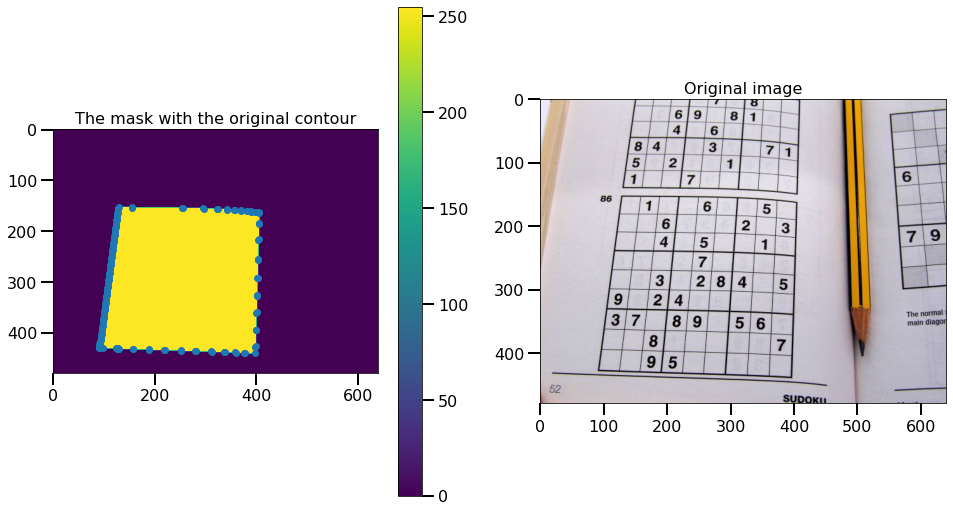

In [5]:
#Finding the contours of the sudoku table

#Contour finding algorithm
contours = cv2.findContours( threshed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]  
#Sorting the contours based on their area, ascending
sorted_contours  = sorted(contours, key = cv2.contourArea, reverse = True)

#Contour with the largest area
max_contour = sorted_contours[0].reshape(-1,2)



#Creating a mask for the previous contour with the largest area
mask = np.zeros_like(gray)
# Draw filled contour in mask
cv2.drawContours(mask, sorted_contours, 0, 255, -1)


fig, ax = plt.subplots(1,2,figsize=[16,9])

mappable = ax[0].imshow(mask)
ax[0].scatter(max_contour[:,0], max_contour[:,1])
plt.colorbar(mappable, ax = ax[0])
ax[0].set_title("The mask with the original contour")

ax[1].imshow(img)
ax[1].set_title("Original image")

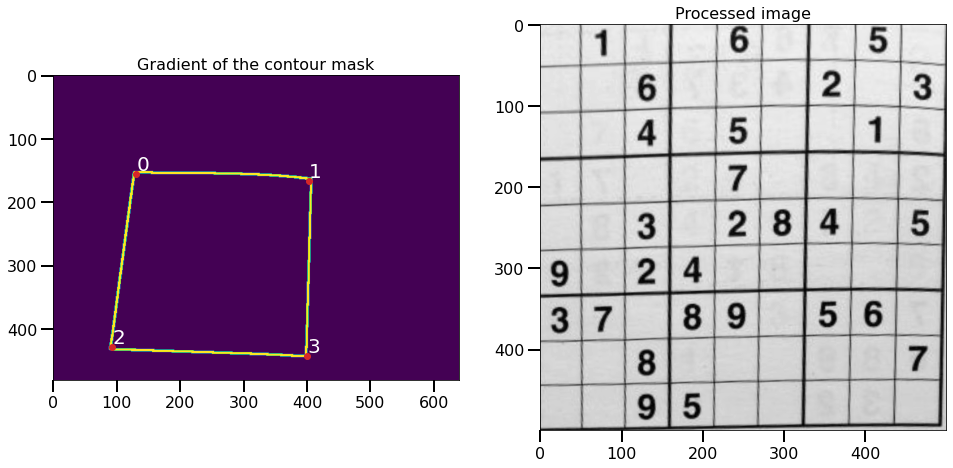

In [6]:
fig, ax = plt.subplots(1,2, figsize=[16,9])
grad_kernel = np.ones((5,5),np.uint8)

#Applying gradient morphological transformation
#Result is the border of the sudoku table (see below on the left)
gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, grad_kernel)
ax[0].imshow(gradient)
ax[0].set_title("Gradient of the contour mask")

#Getting the corner coordinates
corners = cv2.goodFeaturesToTrack(gradient, 4, 0.5, 50).reshape(-1,2)
ax[0].scatter(corners[:,0], corners[:,1], color="tab:red")


#Ordering the corners based on their distance from the (0,0) pixel
ordered_corners = np.array(sorted(corners, key = lambda q:  q[0]**2 + q[1]**2))
for i in range(4):
    ax[0].text(ordered_corners[i,0], ordered_corners[i,1], i,
                fontsize = 20, color = "white", ha = "left", va = "bottom")

#Perspective transformation
transform_to = np.array([ [0,0], [500,0], [0,500] , [500, 500] ] , dtype = np.float32)

matrix = cv2.getPerspectiveTransform(corners, transform_to)
result = cv2.warpPerspective(gray, matrix, (500,500))

flip_result = cv2.flip(result, -1) #we have to flip the picture bc it is upside down for some reason

ax[1].set_title("Processed image")
ax[1].imshow(flip_result, cmap = "gray")

Text(0.5, 1.0, 'Eroded-diluted Canny edges')

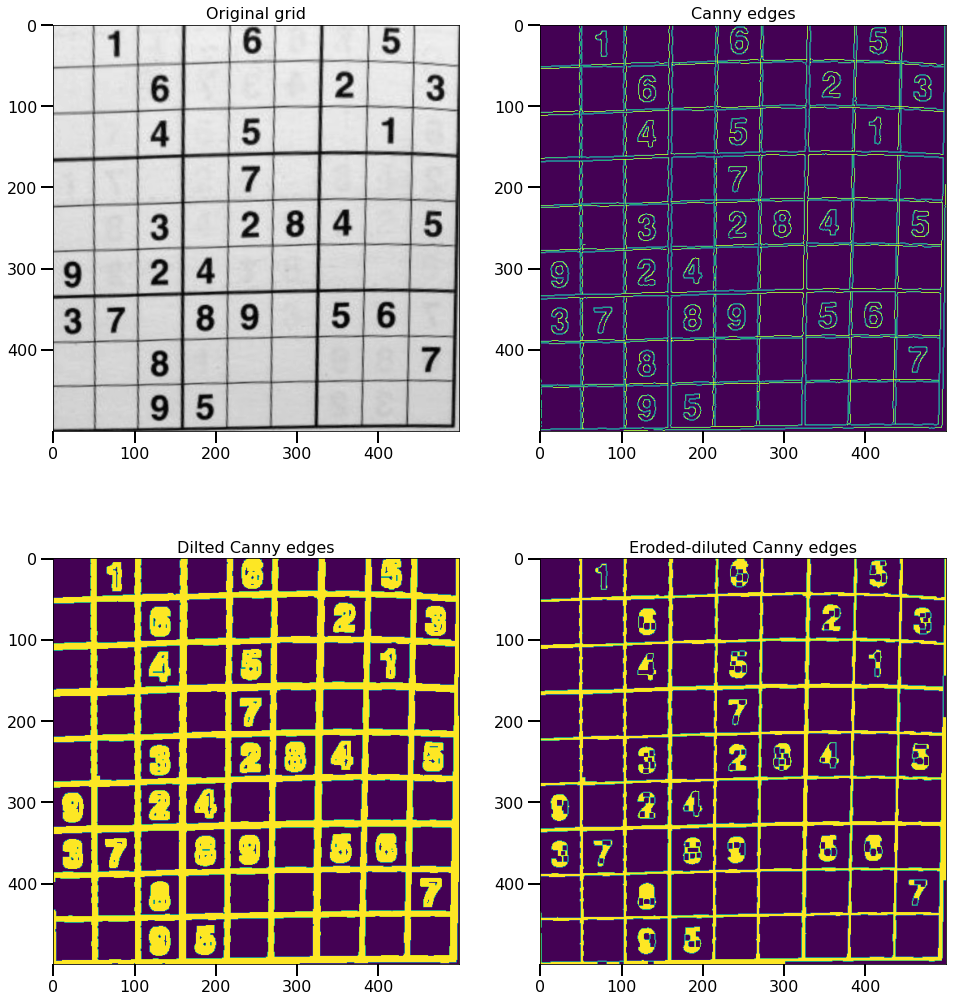

In [7]:
grid = deepcopy(flip_result)

fig, ax = plt.subplots(2,2, figsize=[16,18])


ax[0,0].imshow(grid, cmap ="gray")


canny = cv2.Canny(grid, 50,150 )
ax[0,1].imshow(canny)

#We have to dilate the image, because the gridlines might be separated into two by the Canny edge detection algorithm
dilated_canny = cv2.dilate(canny, np.ones((5,5)))
ax[1,0].imshow(dilated_canny)

#Eroding the borders, otherwise the lines would be too thick
eroded_canny = cv2.erode(dilated_canny, np.ones((5,5)), iterations = 1)
ax[1,1].imshow(eroded_canny)

ax[0,0].set_title("Original grid")
ax[0,1].set_title("Canny edges")
ax[1,0].set_title("Dilted Canny edges")
ax[1,1].set_title("Eroded-diluted Canny edges")

In [8]:
lines = cv2.HoughLines(eroded_canny,1,np.pi/180,200)
lines = lines.reshape(-1,2)


# According to the HoughLines documentation, the theta parameter is the angle formed by 
# the perpendicular distance line of the parametrized line and the horizontal axis.
# The lines I want to keep from the HoughLines collection are the horizontal and 
# vertical lines, which are at 0° and 90°.



def make_filter(direction):

    if direction == "h": #horizontal
        theta_0 = 0
    if direction == "v": #vertical
        theta_0 = np.pi/2

    def filter_lines(line):
        
        rho, theta = line

        if abs(theta - theta_0) < 10**(-6):
            return True
        else:
            return False

    return filter_lines


horizontal_filter = make_filter("h")
vertical_filter = make_filter("v")
horizontal_lines = [*filter(horizontal_filter, lines)]
vertical_lines = [*filter(vertical_filter, lines)]


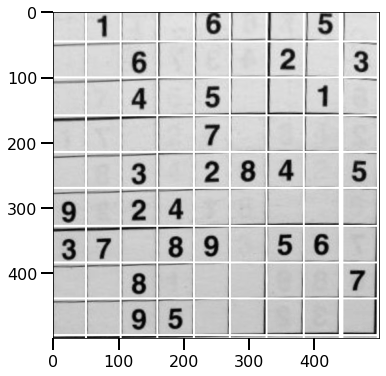

In [9]:
temp = deepcopy(grid)
for rho,theta in horizontal_lines + vertical_lines:
    
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(temp,(x1,y1),(x2,y2),(255),2)

plt.imshow(temp, cmap = "gray")

We can see, that the some one line is much thicker, than the others, so we need to make sure, that the lines are spread more homogenously.

In [10]:
sorted(vertical_lines, key = lambda k: k[0])
# The first parameter is the perpendicular distance of the given line from the origin
# The vertical lines doesn't look to be too close to each other.

[array([46.       ,  1.5707964], dtype=float32),
 array([101.       ,   1.5707964], dtype=float32),
 array([159.       ,   1.5707964], dtype=float32),
 array([215.       ,   1.5707964], dtype=float32),
 array([270.       ,   1.5707964], dtype=float32),
 array([328.       ,   1.5707964], dtype=float32),
 array([384.       ,   1.5707964], dtype=float32),
 array([439.       ,   1.5707964], dtype=float32),
 array([495.       ,   1.5707964], dtype=float32)]

In [11]:
sorted(horizontal_lines, key = lambda k: k[0])
# The last two lines seem to be too dense on the picture,
# as it is also can be concluded based on the first parameters.
# They need to be weeded out.

[array([50.,  0.], dtype=float32),
 array([103.,   0.], dtype=float32),
 array([159.,   0.], dtype=float32),
 array([215.,   0.], dtype=float32),
 array([270.,   0.], dtype=float32),
 array([326.,   0.], dtype=float32),
 array([383.,   0.], dtype=float32),
 array([438.,   0.], dtype=float32),
 array([440.,   0.], dtype=float32),
 array([442.,   0.], dtype=float32),
 array([496.,   0.], dtype=float32),
 array([498.,   0.], dtype=float32)]

In [12]:
sorted_horizontal = np.array(sorted(horizontal_lines, key = lambda k: k[0]))

filtered_horizontal = []

for i in range(len(horizontal_lines)-1):
    if sorted_horizontal[i+1,0] - sorted_horizontal[i,0]  > 6: #subtracting the elements next to each other
        filtered_horizontal.append(sorted_horizontal[i, :])

filtered_horizontal.append(sorted_horizontal[-1, :]) #The last one is not included in the loop
filtered_horizontal = np.array(filtered_horizontal) #converting to nump array

In [13]:
filtered_horizontal

array([[ 50.,   0.],
       [103.,   0.],
       [159.,   0.],
       [215.,   0.],
       [270.,   0.],
       [326.,   0.],
       [383.,   0.],
       [442.,   0.],
       [498.,   0.]], dtype=float32)

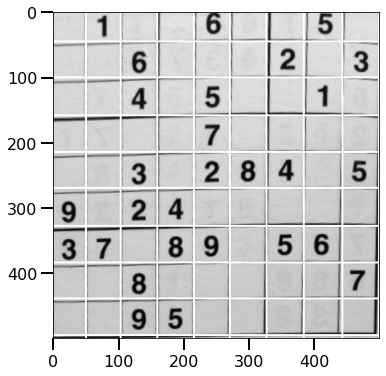

In [14]:
temp = deepcopy(grid)
for rho,theta in list(filtered_horizontal) + vertical_lines:
    
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(temp,(x1,y1),(x2,y2),(255),2)

plt.imshow(temp, cmap = "gray")
#Now the lines seem to be smooth

In [15]:
#Calculating the endpoints of the line
y_endpoints = np.array(sorted(vertical_lines, key =  lambda q: q[0]))[:,0].astype(int)


x_endpoints = filtered_horizontal[:,0].astype(int)


x_endpoints = np.insert(x_endpoints,0,0)
y_endpoints = np.insert(y_endpoints,0,0)


In [16]:
sorted_horizontal, filtered_horizontal

(array([[ 50.,   0.],
        [103.,   0.],
        [159.,   0.],
        [215.,   0.],
        [270.,   0.],
        [326.,   0.],
        [383.,   0.],
        [438.,   0.],
        [440.,   0.],
        [442.,   0.],
        [496.,   0.],
        [498.,   0.]], dtype=float32),
 array([[ 50.,   0.],
        [103.,   0.],
        [159.,   0.],
        [215.,   0.],
        [270.,   0.],
        [326.,   0.],
        [383.,   0.],
        [442.,   0.],
        [498.,   0.]], dtype=float32))

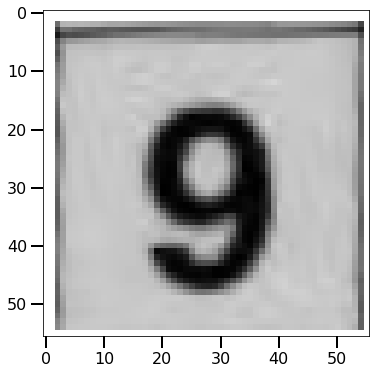

In [17]:
def get_cell(row, col):

    cell = temp[ y_endpoints[ row ] : y_endpoints[ row + 1], 
                 x_endpoints[ col ] : x_endpoints[ col + 1] ]

    return cell

plt.imshow(get_cell(8,2), cmap = "gray")


Text(0.5, 1.0, 'Original grid')

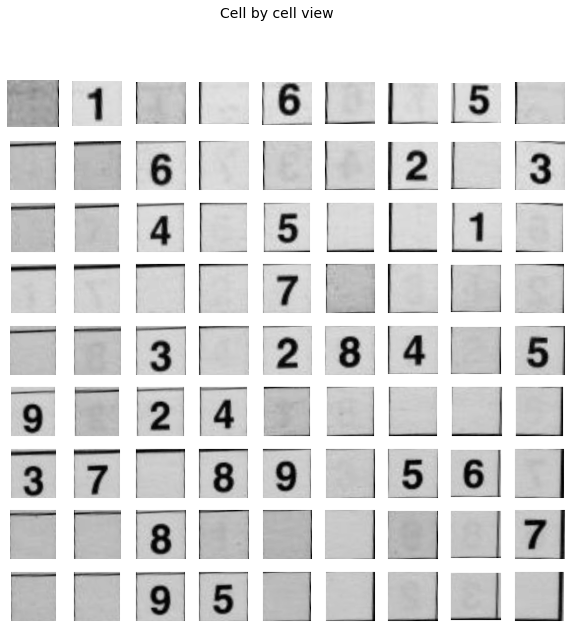

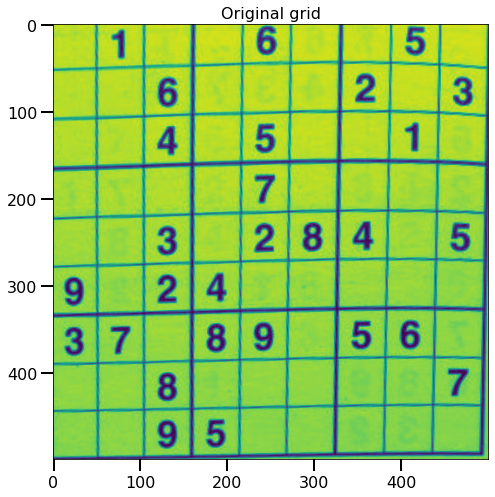

In [18]:
#Redrawing the whole sudoku table cell by cell
fig, ax = plt.subplots(9,9, figsize=[10,10])

for i in range(9):
    for j in range(9):
        ax[i,j].imshow(get_cell(i,j), cmap = "gray")
        ax[i,j].axis("off")
fig.suptitle("Cell by cell view", size = 14)

fig2 = plt.figure(figsize=[8,8])
plt.imshow(grid)
plt.title("Original grid")

In [19]:
# Pytesseract is an open source optical character recognition tool.
# I used it to identify the numbers on this picture.
# Other than that, I could've used open cv template matching, but it would require the individual numbers to 
# be extracted previously.

import pytesseract
pytesseract.pytesseract.tesseract_cmd = "C:\Program Files\Tesseract-OCR\\tesseract.exe"

def number_OCR(row, col):
    thresh = 255 - cv2.threshold(get_cell( row, col ), 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Blur and perform text extraction
    thresh = cv2.GaussianBlur(thresh, (3,3), 1)
    # thresh = get_cell( row, col )
    data = pytesseract.image_to_string(thresh, lang='eng', config='--psm 6 digits')

    try:
        return int(data) % 10 #sometimes the border is get mixed up with a 1, so for    
    except Exception:

        try: # other times some random punctutaion character (, . - or _) gets in the way
            return int(data[0])
        except Exception:
            return 0
    

In [20]:
sudoku = np.empty(shape=(9,9), dtype = object)
for row in range(9):
    for col in range(9):
        sudoku[row, col] = number_OCR(row,col)

(array([[0, 1, 0, 0, 6, 0, 0, 5, 0],
        [0, 0, 6, 0, 0, 0, 2, 0, 3],
        [0, 0, 4, 0, 5, 0, 0, 1, 0],
        [0, 0, 0, 0, 7, 0, 0, 0, 7],
        [0, 0, 3, 0, 2, 8, 4, 0, 5],
        [9, 0, 2, 4, 0, 0, 0, 0, 0],
        [3, 7, 0, 8, 9, 0, 5, 6, 0],
        [0, 0, 8, 0, 0, 0, 0, 0, 7],
        [0, 0, 9, 5, 0, 0, 0, 0, 0]], dtype=object),
 <matplotlib.image.AxesImage at 0x23e629d6190>)

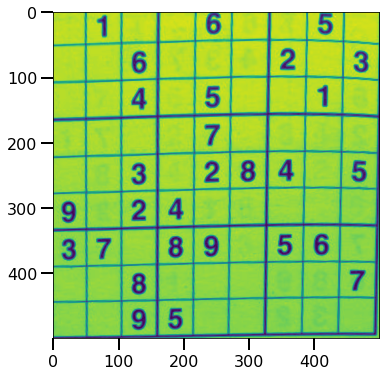

In [21]:
sudoku, plt.imshow(grid)